Enter city name:  Delhi


Latitude: 28.6517178, Longitude: 77.2219388
Weather data for Delhi saved successfully.


C:\Users\agnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1712
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1288
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0973
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0759
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0567
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0503
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0579
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0573
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0571
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0531
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0537
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0493
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0507
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0497
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0463
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━

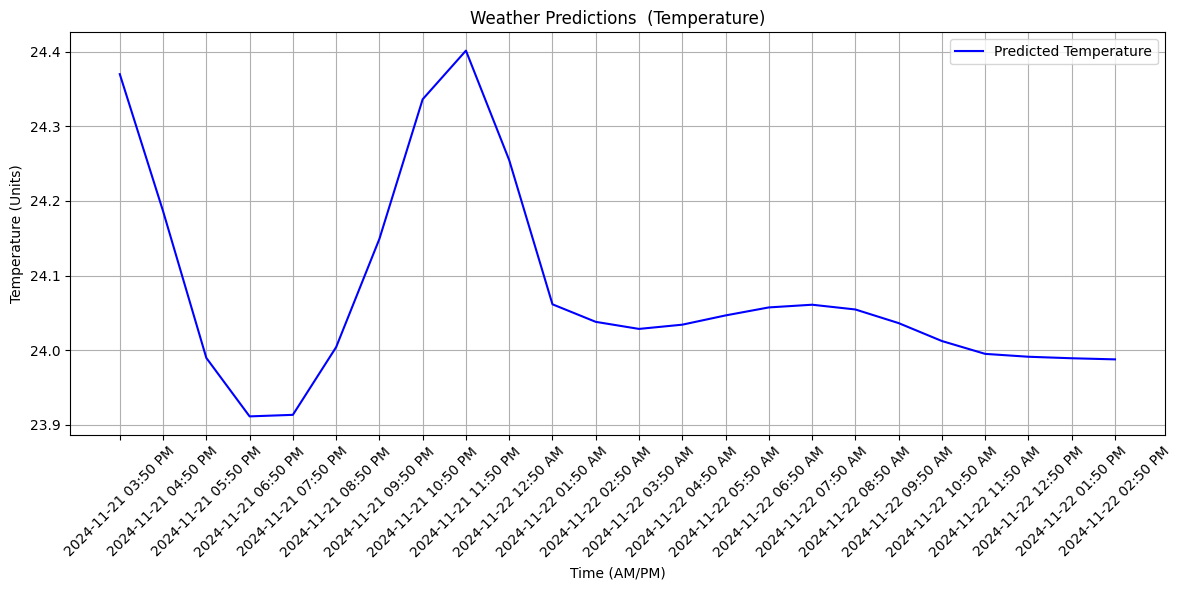

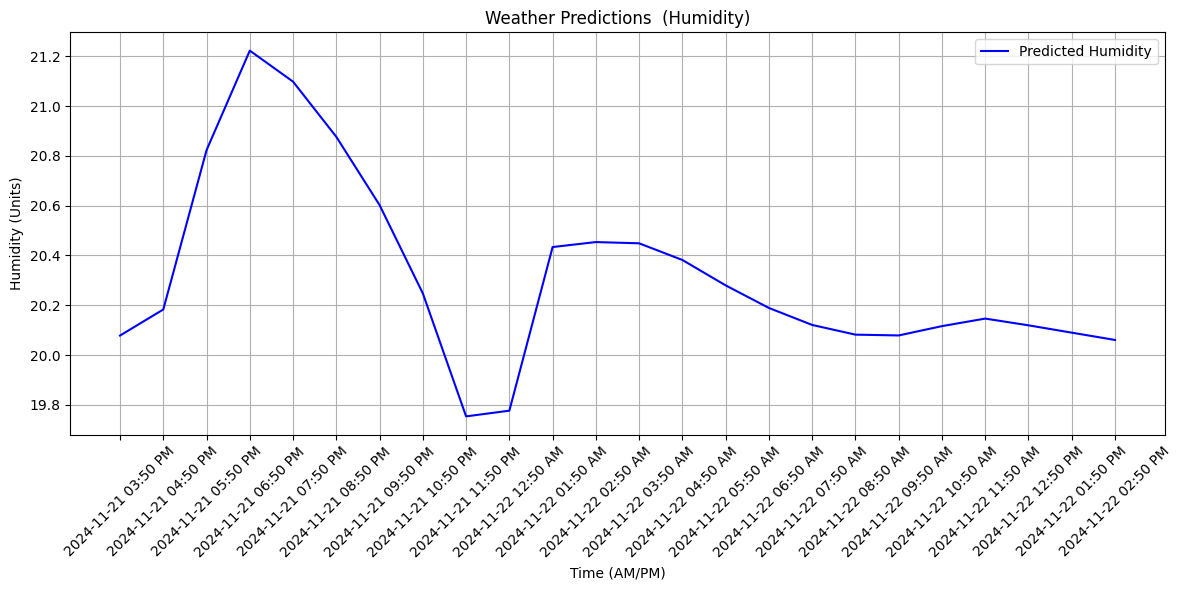

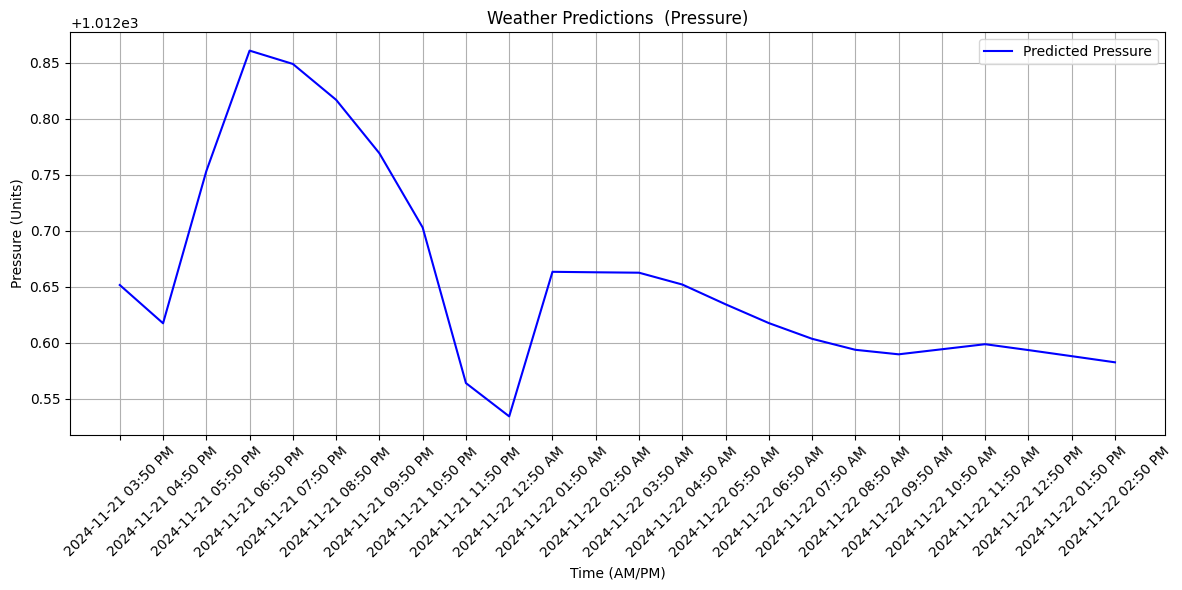

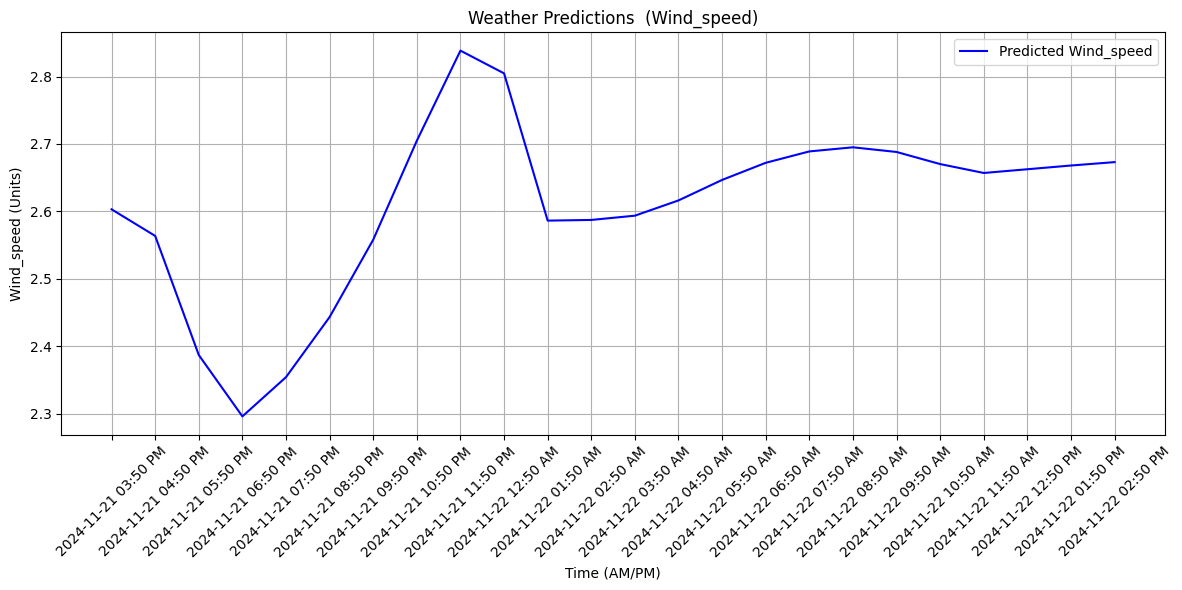

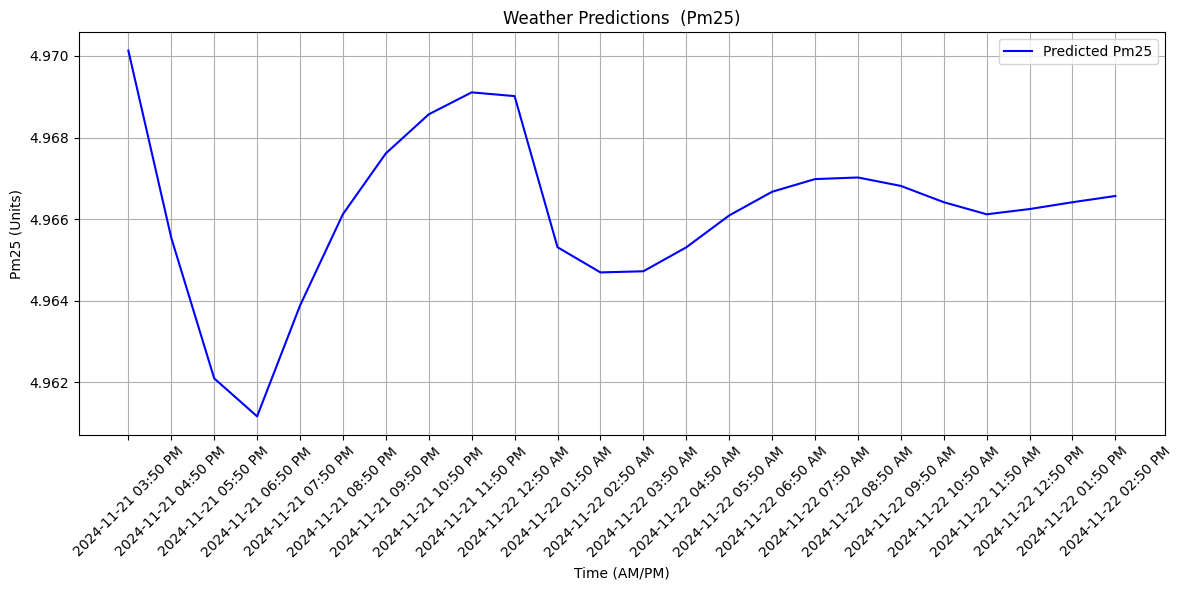

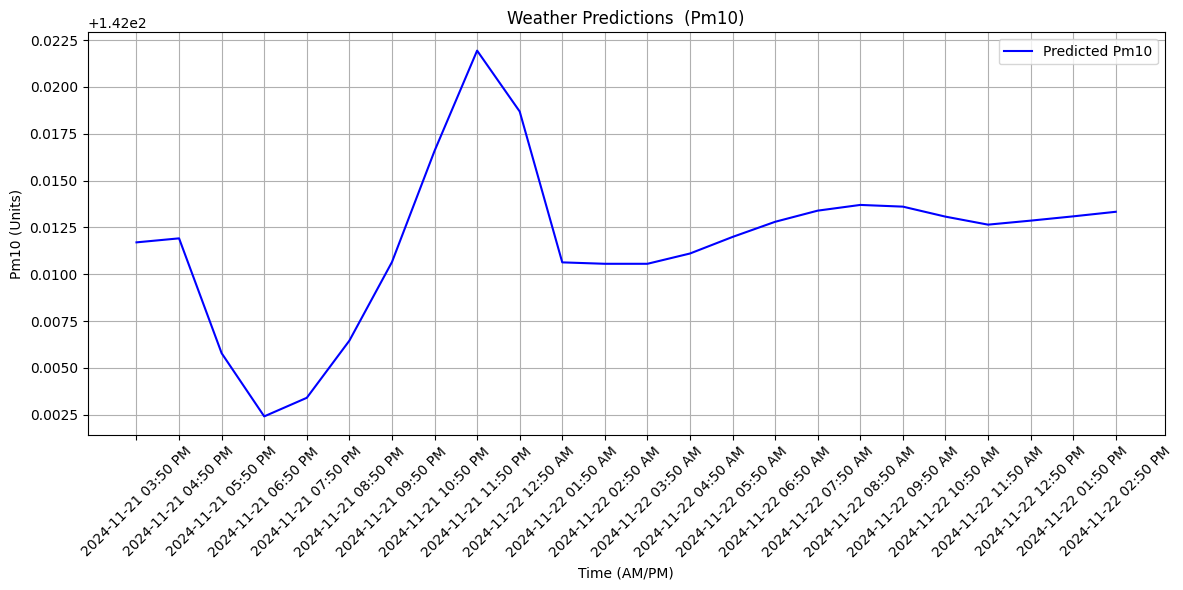

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

API_KEY = ""  

# Fetch latitude and longitude from city name using Geocoding API
def get_lat_lon(city_name, api_key):
    geocode_url = f"http://api.openweathermap.org/geo/1.0/direct?q={city_name}&limit=1&appid={api_key}"
    response = requests.get(geocode_url)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return lat, lon
        else:
            raise Exception("City not found.")
    else:
        raise Exception(f"Geocoding API error: {response.status_code}")


def fetch_weather_data(lat, lon, api_key):
    # URL for weather data
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    response = requests.get(url)
    
    # URL for AQI and pollution data
    aqi_url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
    aqi_response = requests.get(aqi_url)
    
    if response.status_code == 200 and aqi_response.status_code == 200:
        data = response.json()
        aqi_data = aqi_response.json()

        weather_data = []
        for entry in data["list"]:
            dt = datetime.utcfromtimestamp(entry["dt"]).strftime('%Y-%m-%d %H:%M:%S')
            temp = entry["main"]["temp"]
            humidity = entry["main"]["humidity"]
            pressure = entry["main"]["pressure"]
            wind_speed = entry["wind"]["speed"]
            
            # Extract AQI, PM2.5, and PM10 data
            aqi = aqi_data["list"][0]["main"]["aqi"]
            pm25 = aqi_data["list"][0]["components"]["pm2_5"]
            pm10 = aqi_data["list"][0]["components"]["pm10"]
            
            weather_data.append([dt, temp, humidity, pressure, wind_speed, aqi, pm25, pm10])
        
        return weather_data
    else:
        raise Exception(f"API error: {response.status_code}, AQI error: {aqi_response.status_code}")

# Save data to CSV
def save_data_to_csv(data, filename="weather_data.csv"):
    df = pd.DataFrame(data, columns=["timestamp", "temperature", "humidity", "pressure", "wind_speed", "aqi", "pm25", "pm10"])
    df.to_csv(filename, index=False)


# Preprocess data function
def preprocess_data(filename="weather_data.csv", lookback=10):
    df = pd.read_csv(filename)
    
    # Normalizing the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['temperature', 'humidity', 'pressure', 'wind_speed', 'aqi', 'pm25', 'pm10']])
    
    # Ensure enough data
    if len(scaled_data) <= lookback:
        raise ValueError(f"Not enough data. The dataset must have more than {lookback} rows.")

    # Prepare input and output
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        # Collect input data for lookback periods, all features
        X.append(scaled_data[i-lookback:i, :])  # Shape: (lookback, num_features)
        
        # Collect the output data (predicting all features)
        y.append(scaled_data[i, :])  # Shape: (1, 7), predicting all 7 features

    X, y = np.array(X), np.array(y)
    
    # Reshape X to be 3D: [samples, timesteps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))  # (num_samples, lookback, num_features)
    
    return X, y, scaler

# Train LSTM model with dropout and additional layers
def train_lstm(X, y, epochs=50):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2)) 
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))  
    model.add(Dense(50))
    model.add(Dense(7))  
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X, y, batch_size=32, epochs=epochs, verbose=1)
    return model

# Predict the next 24 hours (temperature, humidity, pressure, wind speed, AQI, PM2.5, PM10)
def predict_tomorrow(model, scaler, lookback=10):
    # Generate predictions for the next 24 hours
    last_data = pd.read_csv("weather_data.csv").tail(lookback)
    last_scaled = scaler.transform(last_data[['temperature', 'humidity', 'pressure', 'wind_speed', 'aqi', 'pm25', 'pm10']])

    predictions = []
    current_input = last_scaled.reshape((1, lookback, 7))  # 7 features: temperature, humidity, pressure, wind_speed, aqi, pm25, pm10
    
    for i in range(24):  # Predict for the next 24 hours
        pred = model.predict(current_input)
        predictions.append(pred[0])  # Extract all predicted features
        
        # Update input for next prediction
        current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, 7), axis=1)

    # Inverse transform predictions
    predictions = scaler.inverse_transform(np.array(predictions))
    
    # Generate AM/PM formatted timestamps
    current_time = datetime.now()
    time_stamps = [(current_time + timedelta(hours=i)).strftime('%Y-%m-%d %I:%M %p') for i in range(1, 25)]
    
    return time_stamps, predictions

# Plot predictions
def plot_predictions(filename="weather_data.csv", lookback=10):
    X, y, scaler = preprocess_data(filename, lookback)
    model = train_lstm(X, y, epochs=40)

    # Predict for tomorrow
    time_stamps, predictions = predict_tomorrow(model, scaler, lookback)

    # Plot predictions
    features = ['temperature', 'humidity', 'pressure', 'wind_speed', 'pm25', 'pm10']
    for i, feature in enumerate(features):
        plt.figure(figsize=(12, 6))
        plt.plot(time_stamps, predictions[:, i], label=f"Predicted {feature.capitalize()}", color='b')
        plt.legend()
        plt.title(f"Weather Predictions  ({feature.capitalize()})")
        plt.xlabel("Time (AM/PM)")
        plt.ylabel(f"{feature.capitalize()} (Units)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()



# Main function
def main():
    city_name = input("Enter city name: ")
    
    try:
        
        # Get latitude and longitude for the city
        lat, lon = get_lat_lon(city_name, API_KEY)
        print(f"Latitude: {lat}, Longitude: {lon}")
        
        # Fetch and save weather data (temperature, humidity, pressure, wind speed, AQI, PM2.5, PM10)
        data = fetch_weather_data(lat, lon, API_KEY)
        save_data_to_csv(data)
        print(f"Weather data for {city_name} saved successfully.")
        
        # Plot predictions for tomorrow
        plot_predictions()
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
